In [1]:
%pip install pymorphy2

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import re

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

stopwords_ru = stopwords.words("russian")
# Загрузка данных
dftest = pd.read_csv(
    "https://raw.githubusercontent.com/D4Gj/datasetpromobot/main/train_dataset_train.csv",
    sep=";",
)
dftest["Текст инцидента"] = dftest["Текст инцидента"].str.lower()

def remove_urls(text):
    url_remove = re.compile(r"https?://\S+|www\.\S+")
    return url_remove.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)


def remove_num(text):
    remove = re.sub(r"\d+", "", text)
    return remove


stopwords_ru.extend(
    [
        "на",
        "то",
        "это",
        "так",
        "по",
        "е",
        "зато",
        "есть",
        "ещё",
        "наш",
        "вся",
        "где",
        "г",
        "почему",
        "вы",
        "такие",
        "я",
        "её",
        "сих-пор",
        "ук",
        "это",
        "кто",
        "сейчас",
        "пока",
        "подскажите",
    ]
)


def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]", "", text)
    return punct


# print(stopwords_ru)
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stopwords_ru])


def remove_mention(x):
    text = re.sub(r"@\w+", "", x)
    return text


def remove_hash(x):
    text = re.sub(r"#\w+", "", x)
    return text


def remove_space(text):
    space_remove = re.sub(r"\s+", " ", text).strip()
    return space_remove


dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_urls(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_html(x))
#dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_num(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: punct_remove(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_stopwords(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_mention(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_hash(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_space(x))
dftest.dropna(axis=0)

# Очистка данных
dftest["Текст инцидента"] = dftest["Текст инцидента"].str.lower()
dftest = dftest[dftest["Текст инцидента"].str.len() > 2]
dftest = dftest.dropna(axis=0)

# Стемминг

# Лемматизация
import pymorphy2

morph = pymorphy2.MorphAnalyzer()


def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token and token not in stopwords.words("russian"):
            token = token.strip()
            parsed_token = morph.parse(token)[0]
            normal_form = parsed_token.normal_form
            tokens.append(normal_form)
    if len(tokens) > 2:
        return " ".join(tokens)
    return None


dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lemmatize)
dftest = dftest.dropna(axis=0)

# Разделение данных на обучающую и тестовую выборки


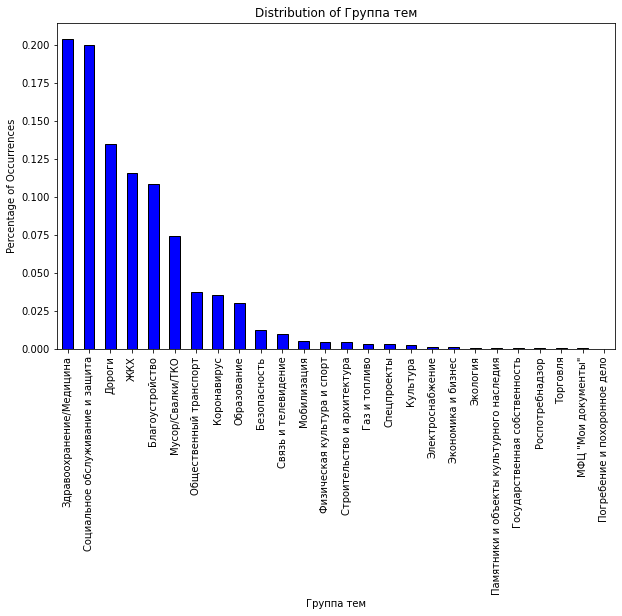

In [4]:
import matplotlib.pyplot as plt

# Calculate the percentage of occurrences for each unique value
label_counts = dftest['Группа тем'].value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Группа тем')
plt.ylabel('Percentage of Occurrences')
plt.title('Distribution of Группа тем')

# Show the plot
plt.show()

In [14]:
X = dftest["Текст инцидента"]
target = "Группа тем"
y = dftest[target]

In [15]:
X_train_pd = pd.DataFrame(X.astype(str))

In [16]:
y_train_pd = pd.DataFrame(y.astype(str))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_pd, y_train_pd, test_size=0.20, random_state=42
)

In [18]:
X_train.astype(str)

,Текст инцидента
18640,здравствуйте принять пожалуйста жалоба такой в...
20340,здравствуйте вопрос январь 2021 приходить муж ...
22676,вокруг монумент трава убрать
23090,добрый вечертак свет улица ваш обещание конец ...
14705,добрый вечер узнать переводить социальный конт...
...,...
12415,добрый вечер конец месяц остаться несколько ча...
22344,добрый день звонить 100500 каждый еле дозванив...
5577,пермь 79922223720 жалоба доводить ваш сведение...
896,добрый день вопрос подавать заявление выплата ...


In [19]:
from catboost import CatBoostClassifier, Pool


def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type="GPU",
        iterations=10000,
        eval_metric="TotalF1",
        od_type="Iter",
        od_wait=1000,
        **kwargs
    )
    
    return model.fit(
        train_pool, eval_set=test_pool, verbose=100, plot=True, use_best_model=True
    )

In [20]:
train_pool = Pool(data=X_train, label=y_train, text_features=["Текст инцидента"])
valid_pool = Pool(data=X_test, label=y_test, text_features=["Текст инцидента"])

In [21]:
model = fit_model(
    train_pool,
    valid_pool,
    learning_rate=0.35,
    dictionaries=[{
        "dictionary_id": "Word",
        "max_dictionary_size": "-1",
        'dictionary_type': 'Bpe',
    }],
    feature_calcers=["BoW:top_tokens_count=10000"],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3502376	test: 0.3573792	best: 0.3573792 (0)	total: 22.6ms	remaining: 3m 46s
100:	learn: 0.7132537	test: 0.6878698	best: 0.6889859 (95)	total: 1.48s	remaining: 2m 25s
200:	learn: 0.7358291	test: 0.7058309	best: 0.7077739 (189)	total: 2.83s	remaining: 2m 17s
300:	learn: 0.7526525	test: 0.7154872	best: 0.7154912 (298)	total: 4.18s	remaining: 2m 14s
400:	learn: 0.7599926	test: 0.7180586	best: 0.7188939 (385)	total: 5.51s	remaining: 2m 11s
500:	learn: 0.7681764	test: 0.7224837	best: 0.7227428 (496)	total: 6.83s	remaining: 2m 9s
600:	learn: 0.7753192	test: 0.7265144	best: 0.7273800 (591)	total: 8.13s	remaining: 2m 7s
700:	learn: 0.7822918	test: 0.7271760	best: 0.7277883 (663)	total: 9.43s	remaining: 2m 5s
800:	learn: 0.7889413	test: 0.7296986	best: 0.7296986 (798)	total: 10.7s	remaining: 2m 3s
900:	learn: 0.7940108	test: 0.7313064	best: 0.7313064 (900)	total: 12s	remaining: 2m 1s
1000:	learn: 0.8004727	test: 0.7322428	best: 0.7322428 (1000)	total: 13.4s	remaining: 2m
1100:	learn:

In [22]:
from datetime import datetime
print(datetime.now())

2023-11-25 10:52:22.133616


In [23]:
model.get_best_score()

{'learn': {'TotalF1': 0.9513134166106536, 'MultiClass': 0.2929555147779458},
 'validation': {'TotalF1': 0.7543745857621305,
  'MultiClass': 0.8370902222117216}}

In [24]:
f1 = model.get_best_score()['validation']['TotalF1']

In [25]:
model.save_model(f'{f1:.3f} {target} {datetime.now()}')

In [26]:
from catboost.utils import get_roc_curve
(fpr, tpr, thresholds) = get_roc_curve(model, train_pool, plot=True)
print(fpr)
print(tpr)
print(thresholds)

CatBoostError: /src/catboost/catboost/private/libs/target/data_providers.cpp:414: Metric Logloss is incompatible with multi-dimensional predictions (should be RMSEWithUncertainty, MultiQuantile, or a multi-classification metric,  or a multi-target metric)